# XLNET

## unlike BERT that uses different mask for some words, XLNET provide all words in advance and different permutation for them

In [2]:
pip install clean-text

  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=740521489f9c9a9b5d1a8c126e23e25384963573c308fd8c7906b56345761806
  Stored in directory: c:\users\sanaz\appdata\local\pip\cache\wheels\fa\7a\e9\22dd0515e1bad255e51663ee513a2fa839c95934c5fc301090
Successfully built emoji
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.5
    Uninstalling wcwidth-0.2.5:
      Successfully uninstalled wcwidth-0.2.5
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install datasets

  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


In [6]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets 
import evaluate
import random

C:\Users\sanaz\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_train = pd.read_csv('emotion-labels-train.csv')
data_test = pd.read_csv('emotion-labels-test.csv')
data_val = pd.read_csv('emotion-labels-val.csv')

In [4]:
data_train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [5]:
data = pd.concat([data_train, data_test, data_val], ignore_index = True)

In [6]:
#remove emojis
data['text_clean'] = data['text'].apply(lambda x: clean(x, no_emoji=True))

In [7]:
#remove punctuation
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('@[^\s]+', '', x))

In [8]:
data.head(20)

,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear an evening of absolute hilarity i don'...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,been waiting all week for this game #cheer #fr...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,": thank you so much, gloria! you're so sweet,..."
4,I feel so blessed to work with the family that...,joy,i feel so blessed to work with the family that...
5,"Today I reached 1000 subscribers on YT!! , #go...",joy,"today i reached 1000 subscribers on yt!! , #go..."
6,"@Singaholic121 Good morning, love! Happy first...",joy,"good morning, love! happy first day of fall. ..."
7,#BridgetJonesBaby is the best thing I've seen ...,joy,#bridgetjonesbaby is the best thing i've seen ...
8,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
9,@IndyMN I thought the holidays could not get a...,joy,i thought the holidays could not get any more...


<AxesSubplot:>

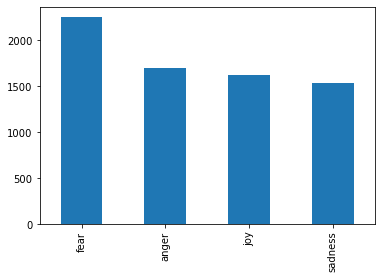

In [9]:
data['label'].value_counts().plot(kind="bar")

In [10]:
g = data.groupby('label')
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

<AxesSubplot:>

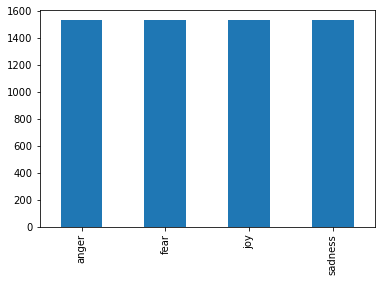

In [11]:
data['label'].value_counts().plot(kind="bar")

In [12]:
data['label_int'] = LabelEncoder().fit_transform(data['label'])

In [13]:
NUM_LABELS = 4

In [14]:
train_split, test_split = train_test_split(data, train_size = 0.8)
train_split, val_split = train_test_split(train_split, train_size = 0.9)

In [15]:
print(len(train_split))
print(len(test_split))
print(len(val_split))

4414
1227
491


In [16]:
train_df = pd.DataFrame({
    "label": train_split.label_int.values,
    "text": train_split.text_clean.values
})

test_df = pd.DataFrame({
    "label": test_split.label_int.values,
    "text": test_split.text_clean.values
})

In [17]:
# format it to dataset dictionary
train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)

In [18]:
dataset_dict = datasets.DatasetDict({"train":train_df, "test":test_df})

In [19]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1227
    })
})

## Create embedding

In [37]:
pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [20]:
# alwayes define tokenizer for the embedding section
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

C:\Users\sanaz\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)

In [22]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/4414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1227 [00:00<?, ? examples/s]

In [23]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1227
    })
})

In [24]:
print(tokenized_datasets['train']['text'][0])

  fingers of fury!


In [25]:
print(tokenized_datasets['train']['input_ids'][0])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3267, 20, 18439, 136, 4, 3]


In [26]:
tokenizer.decode(5)

'<pad>'

In [27]:
print(tokenized_datasets['train']['token_type_ids'][0])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 2]


In [28]:
print(tokenized_datasets['train']['attention_mask'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


In [29]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

## Fine tune a model

In [30]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', 
                                                       num_labels=NUM_LABELS, 
                                                       id2label={0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'})

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
metric = evaluate.load("accuracy")

In [32]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [36]:
pip install accelerate -U

Note: you may need to restart the kernel to use updated packages.


In [33]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=3)

C:\Users\sanaz\anaconda3\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [36]:
trainer = Trainer(
    model=model, 
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics)

In [37]:
trainer.train() # use trainer function from huggingface

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.415917,0.270000
2,No log,1.386812,0.270000


ValueError: You are trying to save a non contiguous tensor: `transformer.layer.0.ff.layer_1.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.

## Evaluate Model

In [ ]:
trainer.evaluate()

In [ ]:
model.save_pretrained("fine_tuned_model")

In [ ]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained("fine_tuned_model")

In [ ]:
clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)

In [ ]:
rand_int = random.randint(0, len(val_split))
print(val_split['text_clean'][rand_int])
answer = clf(val_split['text_clean'][rand_int], top_k=None)
print(answer)